# QOSF_1 - Quantum Circuit Proposals for Binary Classification (Iris)

This notebook implements two distinct variational quantum circuit (VQC) architectures for binary classification using the Iris dataset (setosa vs versicolor). It includes classical preprocessing, training, expressibility analysis (via random-state fidelities), and performance comparison against a classical baseline.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import pennylane as qml
from pennylane import numpy as pnp

np.random.seed(42)
pnp.random.seed(42)


# Kept setosa and versicolor data 

In [2]:
# 1) Load & preprocess data (binary: setosa vs versicolor)
iris = load_iris()
X_full = iris.data
y_full = iris.target
mask = y_full != 2  # remove class 2 (virginica)
X = X_full[mask]
y = y_full[mask]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Labels: {np.unique(y)}")


Train: (80, 4), Test: (20, 4)
Labels: [0 1]


# Classical training

In [3]:
# Classical baseline: logistic regression on the same features
clf = LogisticRegression().fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)
acc_clf = accuracy_score(y_test, y_pred_clf)
print(f"Classical Logistic Regression accuracy: {acc_clf:.3f}")
print(classification_report(y_test, y_pred_clf, target_names=iris.target_names[:2]))


Classical Logistic Regression accuracy: 1.000
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



## Quantum model setup

We use n_qubits = number of features (4). Two distinct ansätze:
- Circuit A: AngleEmbedding + StronglyEntanglingLayers (deep entangling blocks)
- Circuit B: AngleEmbedding + Data re-uploading with BasicEntanglerLayers (embedding between layers)

Measurement: expectation of PauliZ on wire 0 mapped to probability p = (1 + <Z>)/2. Use binary cross-entropy loss.

In [4]:
n_qubits = X_train.shape[1]
n_layers_A = 3
n_layers_B = 4  # with re-uploading

dev_A = qml.device("default.qubit", wires=n_qubits)
dev_B = qml.device("default.qubit", wires=n_qubits)

def prob_from_expval(expval):
    """Map expectation value in [-1,1] to [0,1] probability."""
    # use pnp to keep ArrayBox compatibility
    return (1 + expval) / 2

def binary_cross_entropy(p, y):
    # Use pennylane.numpy (pnp) to support ArrayBox/autograd types
    p = pnp.clip(p, 1e-8, 1 - 1e-8)
    y_arr = pnp.array(y)
    return -(y_arr * pnp.log(p) + (1 - y_arr) * pnp.log(1 - p))


In [5]:
# Circuit A: AngleEmbedding + StronglyEntanglingLayers
def circuit_A(weights, x=None):
    # x: classical features
    qml.templates.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

weight_shape_A = qml.templates.StronglyEntanglingLayers.shape(n_layers_A, n_qubits)
print("weight shape A:", weight_shape_A)

# ensure QNodes use autograd interface for PennyLane/pnp compatibility
qnode_A = qml.QNode(circuit_A, dev_A, interface='autograd')


weight shape A: (3, 4, 3)


In [6]:
# Circuit B: AngleEmbedding + Data re-uploading + BasicEntanglerLayers
def circuit_B(weights, x=None):
    # Data re-uploading: embed x multiple times interleaved with entangler layers
    n_blocks = weights.shape[0]
    for i in range(n_blocks):
        qml.templates.AngleEmbedding(x, wires=range(n_qubits), rotation='X')
        qml.templates.BasicEntanglerLayers(weights[i:i+1].reshape(-1, n_qubits), wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

weight_shape_B = (n_layers_B, n_qubits)
print("weight shape B:", weight_shape_B)
qnode_B = qml.QNode(circuit_B, dev_B, interface='autograd')


weight shape B: (4, 4)


In [7]:
# Helper: predict probability for single sample
def predict_prob(qnode, weights, x):
    # make sure x is a pnp array so outputs are consistent ArrayBox/pnp types
    x = pnp.array(x)
    exp = qnode(weights, x=x)
    return pnp.squeeze(prob_from_expval(exp))


In [8]:
# Expressibility analysis: sample random parameters, get statevectors, compute pairwise fidelities
def get_statevector(qnode, weights, x):
    # Use a QNode that returns state
    dev = qnode.device
    @qml.qnode(dev, interface='autograd')
    def _state(weights, x=None):
        # replicate the circuit but return state
        # here we call the same circuit function used by qnode but request state
        if qnode.func is circuit_A:
            qml.templates.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')
            qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        else:
            n_blocks = weights.shape[0]
            for i in range(n_blocks):
                qml.templates.AngleEmbedding(x, wires=range(n_qubits), rotation='X')
                qml.templates.BasicEntanglerLayers(weights[i:i+1].reshape(-1, n_qubits), wires=range(n_qubits))
        return qml.state()
    return _state(weights, x=x)

def compute_fidelity_stats(qnode, sample_weights_generator, x_fixed, n_samples=50):
    states = []
    for _ in range(n_samples):
        w = sample_weights_generator()
        st = get_statevector(qnode, w, x_fixed)
        states.append(st)
    states = np.array(states)
    # pairwise fidelities
    n = len(states)
    fid_vals = []
    for i in range(n):
        for j in range(i+1, n):
            fid = np.abs(np.vdot(states[i], states[j]))**2
            fid_vals.append(fid)
    fid_vals = np.array(fid_vals)
    return fid_vals


Circuit A fidelities: mean=0.0636, std=0.0589
Circuit B fidelities: mean=0.0628, std=0.0604


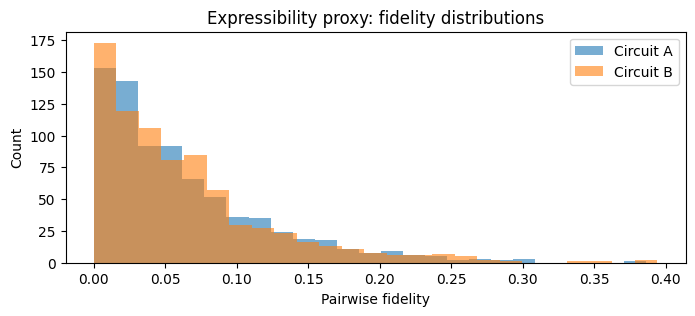

In [9]:
# Generate random weight samplers for A and B
def sampler_A():
    return pnp.random.uniform(0, 2 * np.pi, size=weight_shape_A)

def sampler_B():
    return pnp.random.uniform(0, 2 * np.pi, size=weight_shape_B)

# fixed (zero) input for expressibility test
x_fixed = np.zeros(n_qubits)

fid_A = compute_fidelity_stats(qnode_A, sampler_A, x_fixed, n_samples=40)
fid_B = compute_fidelity_stats(qnode_B, sampler_B, x_fixed, n_samples=40)

print(f"Circuit A fidelities: mean={fid_A.mean():.4f}, std={fid_A.std():.4f}")
print(f"Circuit B fidelities: mean={fid_B.mean():.4f}, std={fid_B.std():.4f}")

plt.figure(figsize=(8,3))
plt.hist(fid_A, bins=25, alpha=0.6, label='Circuit A')
plt.hist(fid_B, bins=25, alpha=0.6, label='Circuit B')
plt.xlabel('Pairwise fidelity')
plt.ylabel('Count')
plt.legend()
plt.title('Expressibility proxy: fidelity distributions')
plt.show()


In [10]:
# Training utilities for VQC
def train_vqc(qnode, init_weights, X_train, y_train, X_val, y_val, epochs=30, lr=0.1):
    weights = pnp.array(init_weights, requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=lr)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    X_train_p = [pnp.array(x) for x in X_train]
    X_val_p = [pnp.array(x) for x in X_val]
    y_train_p = pnp.array(y_train)
    y_val_p = pnp.array(y_val)

    for e in range(epochs):
        # one epoch: simple full-batch gradient step
        def cost(w):
            preds = pnp.stack([predict_prob(qnode, w, x) for x in X_train_p])
            loss = pnp.mean(binary_cross_entropy(preds, y_train_p))
            return loss

        weights = opt.step(cost, weights)

        # validation (outside gradient calculation) - convert to numpy for sklearn metrics
        val_preds_p = pnp.stack([predict_prob(qnode, weights, x) for x in X_val_p])
        # val loss as pnp scalar
        val_loss_p = pnp.mean(binary_cross_entropy(val_preds_p, y_val_p))
        # convert predictions to numpy floats for accuracy_score
        val_preds_np = np.array([float(v) for v in val_preds_p])
        val_acc = accuracy_score(y_val, (val_preds_np > 0.5).astype(int))

        history['val_loss'].append(float(np.array(val_loss_p)))
        history['val_acc'].append(float(val_acc))

    return weights, history


In [11]:
# Initialize and train both circuits
init_w_A = pnp.random.uniform(0, 2 * np.pi, size=weight_shape_A)
init_w_B = pnp.random.uniform(0, 2 * np.pi, size=weight_shape_B)

print('Training Circuit A...')
wA_trained, histA = train_vqc(qnode_A, init_w_A, X_train, y_train, X_test, y_test, epochs=40, lr=0.1)
print('Training Circuit B...')
wB_trained, histB = train_vqc(qnode_B, init_w_B, X_train, y_train, X_test, y_test, epochs=40, lr=0.08)


Training Circuit A...
Training Circuit B...
Training Circuit B...


In [12]:
# Evaluate final performance on test set
probs_A = np.array([predict_prob(qnode_A, wA_trained, x) for x in X_test])
preds_A = (probs_A > 0.5).astype(int)
acc_A = accuracy_score(y_test, preds_A)

probs_B = np.array([predict_prob(qnode_B, wB_trained, x) for x in X_test])
preds_B = (probs_B > 0.5).astype(int)
acc_B = accuracy_score(y_test, preds_B)

print(f"Circuit A accuracy: {acc_A:.3f}")
print(classification_report(y_test, preds_A, target_names=iris.target_names[:2]))
print(f"Circuit B accuracy: {acc_B:.3f}")
print(classification_report(y_test, preds_B, target_names=iris.target_names[:2]))

print(f"Classical baseline accuracy: {acc_clf:.3f}")


Circuit A accuracy: 1.000
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Circuit B accuracy: 0.850
              precision    recall  f1-score   support

      setosa       0.82      0.90      0.86        10
  versicolor       0.89      0.80      0.84        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20

Classical baseline accuracy: 1.000


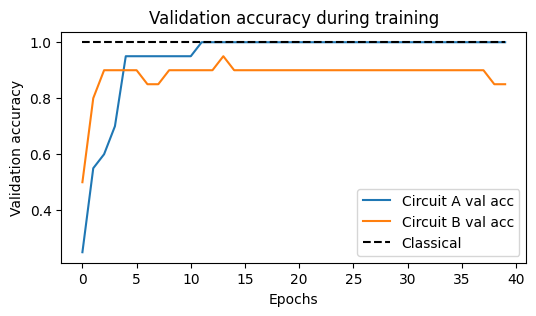

In [13]:
# Simple comparison plot of validation accuracy during training (if available)
plt.figure(figsize=(6,3))
plt.plot(histA['val_acc'], label='Circuit A val acc')
plt.plot(histB['val_acc'], label='Circuit B val acc')
plt.hlines(acc_clf, 0, len(histA['val_acc'])-1, colors='k', linestyles='dashed', label='Classical')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()
plt.title('Validation accuracy during training')
plt.show()
